# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [19]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

from bs4 import BeautifulSoup
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [20]:
# using SQLite Table to read data.
con = sqlite3.connect('E:/appliedaiacourse/assignments/dblite/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

#filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [21]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [22]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [23]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [24]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [25]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [26]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [27]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [28]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [29]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [30]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [15]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no 

In [16]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [17]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Why is this $[...] when the same product is available for $[...] here? />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I'm sorry; b

In [18]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [19]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I am sorry; but these reviews do nobody any good beyond reminding us to look  before ordering.<br /><br />These are chocolate-oatmeal cookies.  If you do not like that combination, do not order this type of cookie.  I find the combo quite nice, really.  The oatmeal sort of "calms" the rich chocolate flavor and gives the cookie sort of a coconut-type consistency.  Now let is also remember that tastes differ; so, I have given my opinion.<br /><br />Then, these are soft, chewy cookies -- as advertised.  They are not "crispy" cookies, or the blurb would say "crispy," rather than "chewy."  I happen to like raw cookie dough; however, I do not see where these taste like raw cookie dough.  Both are soft, however, so is this the confusion?  And, yes, they stick together.  Soft cookies tend to do that.  They are not individually wrapped, which would add to the cost.  Oh y

In [20]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor  and  traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [21]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Wow So far two two star reviews One obviously had no idea what they were ordering the other wants crispy cookies Hey I am sorry but these reviews do nobody any good beyond reminding us to look before ordering br br These are chocolate oatmeal cookies If you do not like that combination do not order this type of cookie I find the combo quite nice really The oatmeal sort of calms the rich chocolate flavor and gives the cookie sort of a coconut type consistency Now let is also remember that tastes differ so I have given my opinion br br Then these are soft chewy cookies as advertised They are not crispy cookies or the blurb would say crispy rather than chewy I happen to like raw cookie dough however I do not see where these taste like raw cookie dough Both are soft however so is this the confusion And yes they stick together Soft cookies tend to do that They are not individually wrapped which would add to the cost Oh yeah chocolate chip cookies tend to be somewhat sweet br br So if you wa

In [22]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [23]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 4986/4986 [00:02<00:00, 2257.00it/s]


In [24]:
preprocessed_reviews[1500]
print(type(preprocessed_reviews))
print(final.shape)

<class 'list'>
(4986, 10)


<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [25]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [24]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aahhhs', 'aback', 'abandon', 'abates', 'abbott', 'abby', 'abdominal', 'abiding', 'ability']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 12997)
the number of unique words  12997


## [4.2] Bi-Grams and n-Grams.

In [26]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.3] TF-IDF

In [27]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely no', 'according']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.4] Word2Vec

In [28]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [29]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('excellent', 0.9934042692184448), ('looking', 0.9928814768791199), ('healthy', 0.9919042587280273), ('overall', 0.9917173385620117), ('worth', 0.9916903972625732), ('terrific', 0.9916651248931885), ('either', 0.9916154742240906), ('amazing', 0.9915229082107544), ('fantastic', 0.9915140867233276), ('anything', 0.9914295673370361)]
[('results', 0.9992072582244873), ('tomatoes', 0.9991599917411804), ('c', 0.9991344213485718), ('become', 0.9991328716278076), ('wife', 0.9991115927696228), ('enjoyed', 0.9990763664245605), ('remember', 0.9990705251693726), ('beef', 0.9990602731704712), ('tassimo', 0.9990425109863281), ('superior', 0.9990386962890625)]


In [30]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3817
sample words  ['product', 'available', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'used', 'ca', 'not', 'beat', 'great', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'removed', 'easily', 'daughter', 'designed', 'printed', 'use', 'car', 'windows', 'beautifully', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'really', 'good', 'idea', 'final', 'outstanding', 'window', 'everybody', 'asks', 'bought', 'made']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [31]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 4986/4986 [00:05<00:00, 910.13it/s] 


4986
50


#### [4.4.1.2] TFIDF weighted W2v

In [32]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [33]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 4986/4986 [00:26<00:00, 191.22it/s]


# [5] Assignment 4: Apply Naive Bayes

<ol>
    <li><strong>Apply Multinomial NaiveBayes on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best Alpha)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Consider a wide range of alpha values for hyperparameter tuning, start as low as 0.00001</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Find the top 10 features of positive class and top 10 features of negative class for both feature sets <font color='red'>Set 1</font> and <font color='red'>Set 2</font> using values of `feature_log_prob_` parameter of  <a href='https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html'>MultinomialNB</a> and print their corresponding feature names</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure. Here on X-axis you will have alpha values, since they have a wide range, just to represent those alpha values on the graph, apply log function on those alpha values.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Multinomial Naive Bayes

## [5.1] Applying Naive Bayes on BOW,<font color='red'> SET 1</font>

In [0]:
# Please write all the code with proper documentation

In [2]:
# the required imports 
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from json import dump,loads
import pandas as pd
import numpy as np
import math
import os
import time    
import enum
import scipy 
import csv

class ratiodatasplit(enum.Enum):
    high=0.2
    medium = 0.3
    low = 0.4
    
class multiNaiveBayes:
    def __init__(self):        
        self.Xdata=[]
        self.Xdatavect = pd.DataFrame()
        self.ydata=pd.DataFrame()
        self.xtrain=pd.DataFrame()
        self.xtest=pd.DataFrame()
        self.xval=pd.DataFrame()
        self.ytrain= pd.Series([])
        self.ytest= pd.Series([])
        self.yval= pd.Series([])
        self.mnb_clf = None
        self.NBayes_alpha = []
        self.yprdprobatrn = []
        self.yprdprobaval = []
        self.yprdprobatest = []
        self.ytrn_predprob_actclf = []
        self.ytst_predprob_actclf = []
        self.rocaucscoretrn = []
        self.rocaucscoreval = []
        self.rocaucscoretest = []
        self.predicted = []
        self.test_predict = []
        self.accuracy_score_val = []
        self.accuracy_score_test = []
        self.clasify_report = []
        self.confsnmtxytstpred = {}
        self.roc_curve_test = {}
        self.clasify_params = {}
        self.graph_params = {}
        self.outputdir = None
        self.opdataitem = {}
        self.opdatajson = {}
        self.count_vect = None
        self.tf_idf_vect = None
        
    def multNBClasify(self):          
        self.mnb_clf = MultinomialNB()        
        return self.mnb_clf

    def getNBClassifier(self):                  
        return self.mnb_clf
    
    @property
    def mnb_clf(self):
        return self._mnb_clf
    
    @mnb_clf.setter
    def mnb_clf(self,new_mnbclf):
        self._mnb_clf = new_mnbclf
		    
    @property
    def Xdata(self):
        return self._Xdata
    
    @Xdata.setter
    def Xdata(self,new_Xdata):
        self._Xdata = new_Xdata
		

    @property
    def Xdatavect(self):
        return self._Xdatavect
    
    @Xdatavect.setter
    def Xdatavect(self,new_Xdatavect):
        self._Xdatavect = new_Xdatavect
		
    @property
    def ydata(self):
        return self._ydata
    
    @ydata.setter
    def ydata(self,new_ydata):
        self._ydata = new_ydata
		
        
    @property
    def xtrain(self):
        return self._xtrain
    
    @xtrain.setter
    def xtrain(self,new_xtrain):
        self._xtrain = new_xtrain        
		
        
    @property
    def xtest(self):
        return self._xtest
    
    @xtest.setter
    def xtest(self,new_xtest):
        self._xtest = new_xtest
		
    @property
    def xval(self):
        return self._xval
    
    @xval.setter
    def xval(self,new_xval):
        self._xval = new_xval 

    @property
    def ytrain(self):
        return self._ytrain
    
    @ytrain.setter
    def ytrain(self,new_ytrain):
        self._ytrain = new_ytrain
		
    @property
    def ytest(self):
        return self._ytest
    
    @ytest.setter
    def ytest(self,new_ytest):
        self._ytest = new_ytest
		
    @property
    def yval(self):
        return self._yval
    
    @yval.setter
    def yval(self,new_yval):
        self._yval = new_yval
		        
    @property
    def yprdprobatrn(self):
        return self._yprdprobatrn

    @yprdprobatrn.setter
    def yprdprobatrn(self,new_yprdprobatrn):
        self._yprdprobatrn = new_yprdprobatrn
		
    @property
    def yprdprobaval (self):
        return self._yprdprobaval

    @yprdprobaval.setter
    def yprdprobaval (self,new_yprdprobaval):
        self._yprdprobaval = new_yprdprobaval
		

    @property
    def yprdprobatest (self):
        return self._yprdprobatest

    @yprdprobatest.setter
    def yprdprobatest (self,new_yprdprobatest):
        self._yprdprobatest = new_yprdprobatest

		
    @property
    def ytrn_predprob_actclf (self):
        return self._ytrn_predprob_actclf

    @ytrn_predprob_actclf.setter
    def ytrn_predprob_actclf (self,new_ytrn_predprob_actclf):
        self._ytrn_predprob_actclf = new_ytrn_predprob_actclf
		
    @property
    def NBayes_alpha (self):
        return self._NBayes_alpha

    @NBayes_alpha.setter
    def NBayes_alpha (self,new_NBayes_alpha):
        self._NBayes_alpha = new_NBayes_alpha
		      

    @property
    def outputdir (self):
        return self._outputdir

    @outputdir.setter
    def outputdir (self,new_outputdir):
        self._outputdir = new_outputdir
		
        
    def setalphaparm(self,prmval):        
        params = {'alpha':prmval}        
        (self.mnb_clf).set_params(**params)        
        return self.mnb_clf
   
    def mnb_fitdata(self):
        mnb_clf.fit(self.xdata,self.ydata)
        return self.mnb_clf

    def mnb_predict(self):
        predicted = mnb_clf.predict(self.xtest)
        return [predicted,mb_clf]

    def hyperparamtuning(self,hyperparam,measure,cvfold=5,vbose=100,njob=1):      

        
        # set the parameter values for hyertuning
        param_grid = {'alpha':hyperparam}
        
        #initialize the classifier
        grdsch_clf = self.getNBClassifier()
        grdschcv = GridSearchCV(grdsch_clf, param_grid,scoring=measure, cv = cvfold, verbose=vbose, n_jobs=njob)
        
        #fit the data with classifier
        grdschcv.fit(self.xtrain,self.ytrain)
        return [grdschcv.best_score_,grdschcv.best_params_,grdschcv]

    def splitdatasets(self,splitratio,proportion,standardise,randomseed=42):
        #split into train and test sets (80/20)        
        
        if standardise :
            if scipy.sparse.issparse(self.Xdata) :
                X1data = self.Xdata
                self.Xdata = X1data.todense()
        """
        print((self.Xdata).shape,(self.ydata).shape)
        #print((self.Xdata),(self.ydata))
        print(proportion)
        """        
        
        if proportion :
            X_train8, X_test8, y_train8, y_test8 = train_test_split(self.Xdata, self.ydata, stratify=self.ydata,test_size=splitratio.value, random_state=randomseed)                         
            X_trn8, X_val8, y_trn8, y_val8   = train_test_split(X_train8, y_train8,stratify=y_train8, test_size=splitratio.value, random_state=randomseed)
        else:
            X_train8, X_test8, y_train8, y_test8 = train_test_split(self.Xdata, self.ydata, test_size=splitratio.value, random_state=randomseed) 
            X_trn8, X_val8, y_trn8, y_val8   = train_test_split(X_train8, y_train8, test_size=splitratio.value, random_state=randomseed)

        # statndardize the data
        if standardise:
            scaler = StandardScaler()              
            train8_scaled = scaler.fit_transform(X_trn8)
            test8_scaled = scaler.transform(X_test8)     
            v8_scaled = scaler.transform(X_val8)
            self.xtrain = train8_scaled
            self.xtest = test8_scaled
            self.xval = v8_scaled
            self.ytrain = y_trn8
            self.ytest = y_test8
            self.yval = y_val8            
        else:
            self.xtrain = X_trn8
            self.xtest = X_test8
            self.xval = X_val8
            self.ytrain = y_trn8
            self.ytest = y_test8
            self.yval = y_val8
            self.xtest = X_test8
           
    def BOWVectorizer(self):
        #BoW
        self.count_vect = CountVectorizer(max_features=1000) #in scikit-learn
        self.count_vect.fit(self.xtrain)
        print("some feature names ", self.count_vect.get_feature_names()[:10])
        print('='*50)

        self.xtrain = self.count_vect.transform(self.xtrain)
        self.xtest = self.count_vect.transform(self.xtest)
        self.xval = self.count_vect.transform(self.xval)
        print("the type of count vectorizer ",type(self.xtrain))
        print("the shape of out text BOW vectorizer ",self.xtrain.get_shape())
        print("the number of unique words ", self.xtrain.get_shape()[1])

        
    def tfIdfVectorizer(self):
        self.tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10,)
        self.tf_idf_vect.fit(self.xtrain)
        print("some sample features(unique words in the corpus)",self.tf_idf_vect.get_feature_names()[0:10])
        print('='*50)

        self.xtrain = self.tf_idf_vect.transform(self.xtrain)
        self.xtest = self.tf_idf_vect.transform(self.xtest)
        self.xval  = self.tf_idf_vect.transform(self.xval)
        print("the type of count vectorizer ",type(self.xtrain))
        print("the shape of out text TFIDF vectorizer ",self.xtrain.get_shape())
        print("the number of unique words including both unigrams and bigrams ", self.xtrain.get_shape()[1])        

    def tstloop(self,endval):
        i = 0.00000000001
        while(i <= endval):
            print(i)
            i = i*10
            
    def calcrocaucscore_naivebayes(self,endval):
        alpha_start = 0.00000000001
        while(alpha_start <= endval):
            
            # set alpha param for classifier
            self.setalphaparm(alpha_start)
            
            # fit the x-train model            
            (self.mnb_clf).fit(self.xtrain,self.ytrain)
            self.yprdprobatrn =  (self.mnb_clf).predict_proba(self.xtrain)[:,1]
            (self.rocaucscoretrn).append(roc_auc_score(self.ytrain,self.yprdprobatrn))
            print('Fitting probability generation and roc auc score generation for training data complete...')

            #fit the validation model
            (self.mnb_clf).fit(self.xval,self.yval)
            self.yprdprobaval =  (self.mnb_clf).predict_proba(self.xval)[:,1]
            (self.rocaucscoreval).append(roc_auc_score(self.yval,self.yprdprobaval))
            print('Fitting probability generation and roc auc score generation for validation data complete...')

            # predict the labels for validation
            self.predicted = (self.mnb_clf).predict(self.xval)
            
            # calculate accuracy_score
            self.accuracy_score_val = accuracy_score(self.yval, self.predicted)
            
            print('Predicting labels for training data complete...')
            
            #set alpha to the next value
            (self.NBayes_alpha).append(alpha_start)
            alpha_start = alpha_start * 10
            
        print('Function exiting...')
            
    def actualClasifier_naivebayes(self,parm_alpha):
        self.setalphaparm(parm_alpha)
        (self.mnb_clf).fit(self.xtest,self.ytest)
        
        # predict xtest labels
        self.test_predict = (self.mnb_clf).predict(self.xtest)
        
        #store the classifier parameters
        self.clasify_params['clfparams'] = (self.mnb_clf).get_params(deep=True)
        
        # calculate accuracy_score
        self.accuracy_score_test = accuracy_score(self.ytest, self.test_predict)
        
        # generate classification report 
        #classification_report(self.ytest, self.test_predict)
        
        # confusion matrix for ytest
        tn, fp, fn, tp = confusion_matrix(self.ytest, self.test_predict ).ravel()
        self.confsnmtxytstpred['tn'] = tn
        self.confsnmtxytstpred['fp'] = fp
        self.confsnmtxytstpred['fn'] = fn
        self.confsnmtxytstpred['tp'] = tp
        
        # predict probabilites  from xtrain for roc_curve
        self.ytrn_predprob_actclf = (self.mnb_clf).predict_proba(self.xtrain)[:,1]
        fpr_trn, tpr_trn, thrshld_trn = roc_curve(self.ytrain, self.ytrn_predprob_actclf)
        
        # predict probabilites  from xtest for roc_curve
        self.ytst_predprob_actclf = (self.mnb_clf).predict_proba(self.xtest)[:,1]
        fpr, tpr, thrshld_test = roc_curve(self.ytest,self.ytst_predprob_actclf)
        
        # store the above into the dictionary
        self.roc_curve_test['fpr_trn'] = fpr_trn
        self.roc_curve_test['tpr_trn'] =  tpr_trn
        self.roc_curve_test['thrshld_trn'] = thrshld_trn
        self.roc_curve_test['fpr'] = fpr
        self.roc_curve_test['tpr'] = tpr
        self.roc_curve_test['thrshld_test'] = thrshld_test


   

    def exportopdatatocsv(self,name,data):
        fname = self.outputdir + "/" + name + '.csv'
        with open(fname,"w") as csvFile:
                wr=csv.writer(csvFile,quoting=csv.QUOTE_NONE,escapechar='\\')
                wr.writerow(data)
                
    def exportopdatatojson(self):
        self.opdataitem['NBayes_alpha'] = self.NBayes_alpha
        self.opdataitem['yprdprobatrn'] = self.yprdprobatrn
        self.opdataitem['yprdprobaval'] = self.yprdprobaval
        self.opdataitem['yprdprobatest'] = self.yprdprobatest
        self.opdataitem['ytrn_predprob_actclf'] = self.ytrn_predprob_actclf
        self.opdataitem['ytst_predprob_actclf'] = self.ytst_predprob_actclf
        self.opdataitem['rocaucscoretrn'] = self.rocaucscoretrn
        self.opdataitem['rocaucscoreval'] = self.rocaucscoreval
        self.opdataitem['rocaucscoretest'] = self.rocaucscoretest
        self.opdataitem['predicted'] = self.predicted
        self.opdataitem['test_predict'] = self.test_predict
        self.opdatajson = {
                            'Model':'NBayesClasify',
                            'Opdata': self.opdataitem
                           }
        fname = self.outputdir + "/" + 'NBayesclasify.json'
        
        fp = open(fname, 'a+')
        dump(self.opdatajson, fp, indent=4)
        fp.close()

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

class drawgraphs:
    def __init__(self):
        self.graph_parameters= {}
        self.plt = None
        
    #self.graph_parameters['']=    
    def setdefaultparm(self):
        self.Xdata=pd.DataFrame()
        self.ydatatrn=pd.DataFrame()
        self.ydataval=pd.DataFrame()
        self.graph_parameters['figsize_x']= 16
        self.graph_parameters['figsize_y']= 16 
        self.graph_parameters['show_legnd']= False
        self.graph_parameters['show_grid']= True        
        self.graph_title = None
        self.legnd_1x = None
        self.legnd_2 = None
        self.label_x = None
        self.label_y = None
        
		    
    @property
    def Xdata(self):
        return self._Xdata
    
    @Xdata.setter
    def Xdata(self,new_Xdata):
        self._Xdata = new_Xdata
		
        
    @property
    def ydatatrn(self):
        return self._ydatatrn
    
    @ydatatrn.setter
    def ydatatrn(self,new_ydatatrn):
        self._ydatatrn = new_ydatatrn
		
    @property
    def ydataval(self):
        return self._ydataval
    
    @ydataval.setter
    def ydataval(self,new_ydataval):
        self._ydataval = new_ydataval
		
        
    @property
    def graph_title(self):
        return self._graph_title
    
    @graph_title.setter
    def graph_title(self,new_title):
        self._graph_title = new_title
		
        
    @property
    def legnd_1(self):
        return self._legnd_1
    
    @legnd_1.setter
    def legnd_1(self,new_legnd1):
        self._legnd_1 = new_legnd1
		

    @property
    def legnd_2(self):
        return self._legnd_2
    
    @legnd_2.setter
    def legnd_2(self,new_legnd2):
        self._legnd_2 = new_legnd2
		

    @property
    def label_x(self):
        return self._label_x
    
    @label_x.setter
    def label_x(self,new_lblx):
        self._label_x = new_lblx
		

    @property
    def label_y(self):
        return self._label_y
    
    @label_y.setter
    def label_y(self,new_labely):
        self._label_y = new_labely
		
    def rocacuscoregraph(self):
        plt.figure(figsize=(self.graph_parameters['figsize_x'],self.graph_parameters['figsize_y']))
        y1=np.asarray(self.ydatatrn)
        y1 = y1.reshape(-1,1)
        y2=np.asarray(self.ydataval)
        y2 = y2.reshape(-1,1)
        plt.plot(self.Xdata,y1, label=self.legnd_1)
        plt.plot(self.Xdata,y2, label=self.legnd_2)
        plt.xlabel(self.label_x)
        plt.ylabel(self.label_y)
        plt.title(self.graph_title)
        plt.grid(self.graph_parameters['show_grid'])
        
        if self.graph_parameters['show_legnd'] :
            plt.legend()
        plt.show()
        
    def constructgraph(self, fpr_trn, tpr_trn, fpr, tpr):
        plt.figure(figsize=(self.graph_parameters['figsize_x'],self.graph_parameters['figsize_y']))
        plt.plot([0,1],[0,1],'k--')        
        plt.plot(fpr_trn,tpr_trn, label=self.legnd_1)
        plt.plot(fpr,tpr, label=self.legnd_2)        
        plt.xlabel(self.label_x)
        plt.ylabel(self.label_y)
        plt.title(self.graph_title)
        plt.grid(self.graph_parameters['show_grid'])
        
        if self.graph_parameters['show_legnd'] :
            plt.legend()
        plt.show()
        
    def draw_table(self,data):
        colors = [["#56b5fd","w"],[ "w","#1ac3f5"]]
        table = plt.table(cellText=data,rowLabels=['Actual:\n NO','Actual: \nYES'], colLabels=['Predicted: \n NO', 'Predicted: \n YES'], loc='center', 
                          cellLoc='center',cellColours=colors, colColours=['Red', 'Green'],rowColours=['Yellow','Green'])

        table.set_fontsize(24)
        for i in range(0,3):
            for j in range(-1,2):
                if (i==0 and j == -1):
                    continue
                table.get_celld()[(i,j)].set_height(0.5)
                table.get_celld()[(i,j)].set_width(0.5)
                table.get_celld()[(i,j)].set_linewidth(4)
        plt.axis('off')
        plt.show() 
        
    def draw_accscore(self,data):
        #colors = [["#56b5fd","w"]]
        table = plt.table(cellText=data,colLabels=['Validation','Test'], rowLabels=['Accuracy\nScore'], loc='center', 
                          cellLoc='center', rowColours=['Green'],colColours=["#56b5fd","#1ac3f5"])

        table.set_fontsize(24)
        for i in range(0,2):
            for j in range(-1,2):
                if (i==0 and j == -1):
                    continue
                table.get_celld()[(i,j)].set_height(0.5)
                table.get_celld()[(i,j)].set_width(0.8)
                table.get_celld()[(i,j)].set_linewidth(4)
        plt.axis('off')
        plt.show()  
        
    
    def draw_posnegwords(self,data):
        #colors = [["#56b5fd","w"]]
        table = plt.table(cellText=data,colLabels=['Postive','Negative'], rowLabels=['1','2','3','4','5','6','7','8','9','10'], loc='center', 
                          cellLoc='center',colColours=["#56b5fd","#1ac3f5"])

        table.set_fontsize(20)
        for i in range(0,11):
            for j in range(-1,2):
                if (i==0 and j == -1):
                    continue
                #if (i==0 and j == 2):
                    #continue
                table.get_celld()[(i,j)].set_height(0.3)
                table.get_celld()[(i,j)].set_width(0.8)
                table.get_celld()[(i,j)].set_linewidth(4)
        plt.axis('off')
        plt.show()  

In [6]:
def load_data():
    
    import pickle 

    with open ('E:/appliedaiacourse/assignments/dblite/preproc_xtrain', 'rb') as fp:
        xtrain_preproc = pickle.load(fp)

    with open ('E:/appliedaiacourse/assignments/dblite/preproc_xtest', 'rb') as fp:
        xtest_preproc = pickle.load(fp)

    with open ('E:/appliedaiacourse/assignments/dblite/preproc_xval', 'rb') as fp:
        xval_preproc = pickle.load(fp)

    with open ('E:/appliedaiacourse/assignments/dblite/ytrain', 'rb') as fp:
        ytrain = pickle.load(fp)

    with open ('E:/appliedaiacourse/assignments/dblite/ytest', 'rb') as fp:
        ytest = pickle.load(fp)

    with open ('E:/appliedaiacourse/assignments/dblite/yval', 'rb') as fp:
        yval = pickle.load(fp)

    return [xtrain_preproc,xtest_preproc,xval_preproc,ytrain,ytest,yval]



In [4]:
#instantiate the NaiveBayes object and Multinomial Naive Bayes classifier
mnbayes = multiNaiveBayes()
mnbayes_clf = mnbayes.multNBClasify()

In [7]:
#load data
mnbayes.xtrain,mnbayes.xtest,mnbayes.xval, mnbayes.ytrain,mnbayes.ytest,mnbayes.yval = load_data()

In [8]:
#Bag of words vectorizer with max featues 1000
mnbayes.BOWVectorizer()

some feature names  ['abl', 'absolut', 'acid', 'across', 'actual', 'ad', 'add', 'addict', 'addit', 'advertis']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (64000, 1000)
the number of unique words  1000


In [9]:
#the calssifier uses distance measure hence data has to be scaled
scaler = StandardScaler(with_mean=False)              
bowtrain_scaled = scaler.fit_transform(mnbayes.xtrain.toarray())
bowtest_scaled = scaler.transform(mnbayes.xtest)     
bowv_scaled = scaler.transform(mnbayes.xval)

In [10]:
# cross check data shapes
print(bowtrain_scaled.shape)
print(bowtest_scaled.shape)
print(bowv_scaled.shape)
print((mnbayes.ytrain).shape)
print((mnbayes.ytest).shape)
print((mnbayes.yval).shape)

(64000, 1000)
(20000, 1000)
(16000, 1000)
(64000,)
(20000,)
(16000,)


In [11]:
print(mnbayes.getNBClassifier())
#hyper parameter tuning to find  alpha 
return_63 = mnbayes.hyperparamtuning([0.00000000001,0.0000000001,0.0000000001,0.000000001,0.00000001,0.0000001,0.000001,0.00001,0.0001,0.001,0.01,1,10,100,1000,10000,100000,1000000,10000000,100000000,1000000000,10000000000],'roc_auc')

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
Fitting 5 folds for each of 22 candidates, totalling 110 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] alpha=1e-11 .....................................................
[CV] ............. alpha=1e-11, score=0.895692105573748, total=   0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[CV] alpha=1e-11 .....................................................
[CV] ............. alpha=1e-11, score=0.895559643229585, total=   0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[CV] alpha=1e-11 .....................................................
[CV] ............ alpha=1e-11, score=0.9094128647360861, total=   0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[CV] alpha=1e-11 .....................................................
[CV] ............ alpha=1e-11, score=0.9029790428364183, tota

[CV] alpha=1e-05 .....................................................
[CV] ............. alpha=1e-05, score=0.895559643229585, total=   0.0s
[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed:    3.9s remaining:    0.0s
[CV] alpha=1e-05 .....................................................
[CV] ............ alpha=1e-05, score=0.9094128647360861, total=   0.0s
[Parallel(n_jobs=1)]: Done  38 out of  38 | elapsed:    4.0s remaining:    0.0s
[CV] alpha=1e-05 .....................................................
[CV] ............ alpha=1e-05, score=0.9029790428364183, total=   0.0s
[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed:    4.1s remaining:    0.0s
[CV] alpha=1e-05 .....................................................
[CV] ............ alpha=1e-05, score=0.8963891938286019, total=   0.0s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    4.2s remaining:    0.0s
[CV] alpha=0.0001 ....................................................
[CV] ............ alpha=0.0001, score=0.8

[CV] alpha=1000 ......................................................
[CV] .............. alpha=1000, score=0.669610062099106, total=   0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    8.2s remaining:    0.0s
[CV] alpha=1000 ......................................................
[CV] ............. alpha=1000, score=0.6578182033785962, total=   0.0s
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:    8.3s remaining:    0.0s
[CV] alpha=10000 .....................................................
[CV] ............ alpha=10000, score=0.5371599026891116, total=   0.0s
[Parallel(n_jobs=1)]: Done  76 out of  76 | elapsed:    8.4s remaining:    0.0s
[CV] alpha=10000 .....................................................
[CV] ............ alpha=10000, score=0.5474771640538865, total=   0.0s
[Parallel(n_jobs=1)]: Done  77 out of  77 | elapsed:    8.5s remaining:    0.0s
[CV] alpha=10000 .....................................................
[CV] ............ alpha=10000, score=0.54

In [13]:
#print the results of the gridsearchCV
print(return_63[0])  # best score
print(return_63[1])  # best alpha = 10
print(return_63[2])

0.9001319166904739
{'alpha': 10}
GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid={'alpha': [1e-11, 1e-10, 1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000, 100000000, 1000000000, 10000000000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=100)


In [14]:
#calculate roauc score varying alpha
mnbayes.calcrocaucscore_naivebayes(100000000)

Fitting probability generation and roc auc score generation for training data complete...
Fitting probability generation and roc auc score generation for validation data complete...
Predicting labels for training data complete...
Fitting probability generation and roc auc score generation for training data complete...
Fitting probability generation and roc auc score generation for validation data complete...
Predicting labels for training data complete...
Fitting probability generation and roc auc score generation for training data complete...
Fitting probability generation and roc auc score generation for validation data complete...
Predicting labels for training data complete...
Fitting probability generation and roc auc score generation for training data complete...
Fitting probability generation and roc auc score generation for validation data complete...
Predicting labels for training data complete...
Fitting probability generation and roc auc score generation for training data co

In [15]:
print(mnbayes.rocaucscoretrn)
print(mnbayes.rocaucscoreval)
print( mnbayes.NBayes_alpha)

[0.9053365680876713, 0.9053365680876713, 0.9053365680876713, 0.9053365680876713, 0.9053365680876713, 0.9053365700261883, 0.9053365758417397, 0.9053365797187738, 0.90533656227212, 0.9053368045867547, 0.9053378688326301, 0.9053488893022151, 0.9051831557846834, 0.8919818447950495, 0.693085396430503, 0.5464037119686502, 0.514971675280183, 0.5096905828988257, 0.5091040108934115, 0.5090437501515437]
[0.9163071019388954, 0.9163071019388954, 0.9163071019388954, 0.9163071019388954, 0.9163071019388954, 0.9163071327455263, 0.9163071327455263, 0.9163071943587884, 0.9163067014526929, 0.916305715640502, 0.9163012948889582, 0.9161995867968202, 0.9123514072961931, 0.8161240150503948, 0.5781911418366863, 0.5203568985165499, 0.5087069705301304, 0.5072543146535068, 0.5071018218302195, 0.5070857407688547]
[1e-11, 9.999999999999999e-11, 9.999999999999999e-10, 9.999999999999999e-09, 9.999999999999998e-08, 9.999999999999997e-07, 9.999999999999997e-06, 9.999999999999998e-05, 0.0009999999999999998, 0.009999999

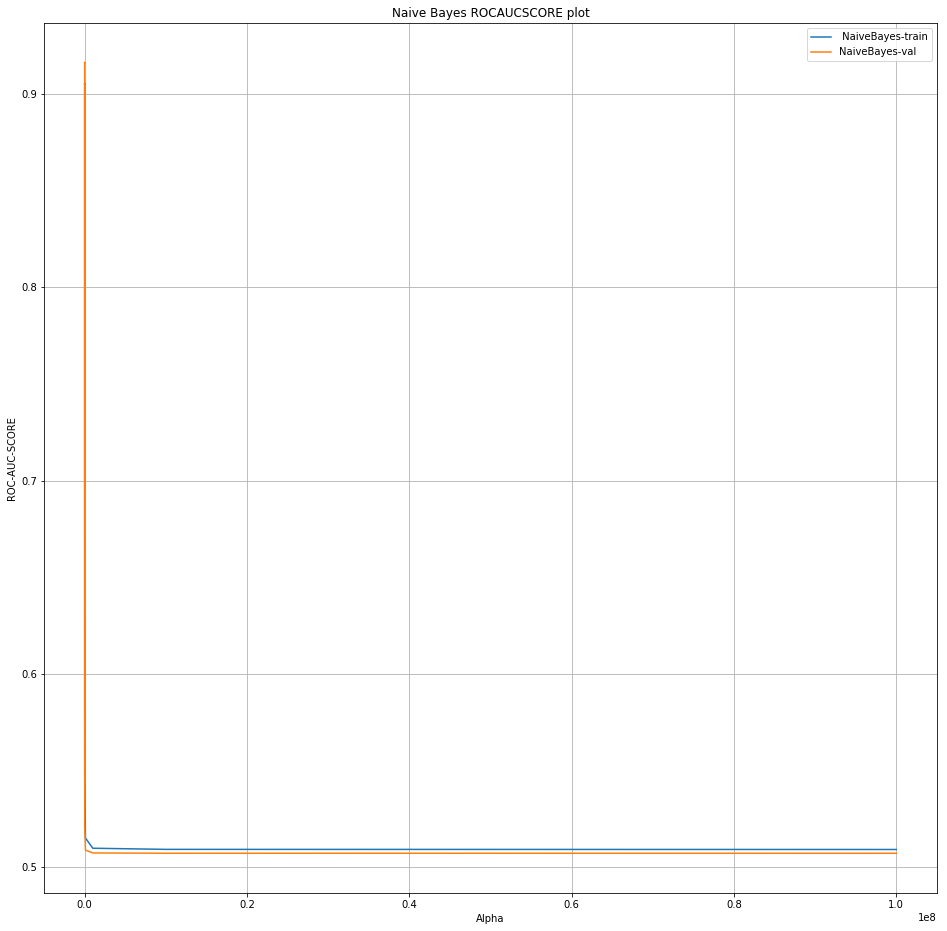

In [16]:
# display rocauc graph
displaygraph = drawgraphs()
displaygraph.setdefaultparm()
displaygraph.graph_title='Naive Bayes ROCAUCSCORE plot'
displaygraph.legnd_1 = ' NaiveBayes-train'
displaygraph.legnd_2 = 'NaiveBayes-val'
displaygraph.graph_parameters['show_legnd']= True
displaygraph.label_x='Alpha'
displaygraph.label_y='ROC-AUC-SCORE'
displaygraph.Xdata = mnbayes.NBayes_alpha
displaygraph.ydatatrn = mnbayes.rocaucscoretrn
displaygraph.ydataval = mnbayes.rocaucscoreval
displaygraph.rocacuscoregraph()

In [21]:
#process test data using the hyper parameter tuned alpha value of 10 
mnbayes.actualClasifier_naivebayes(10)

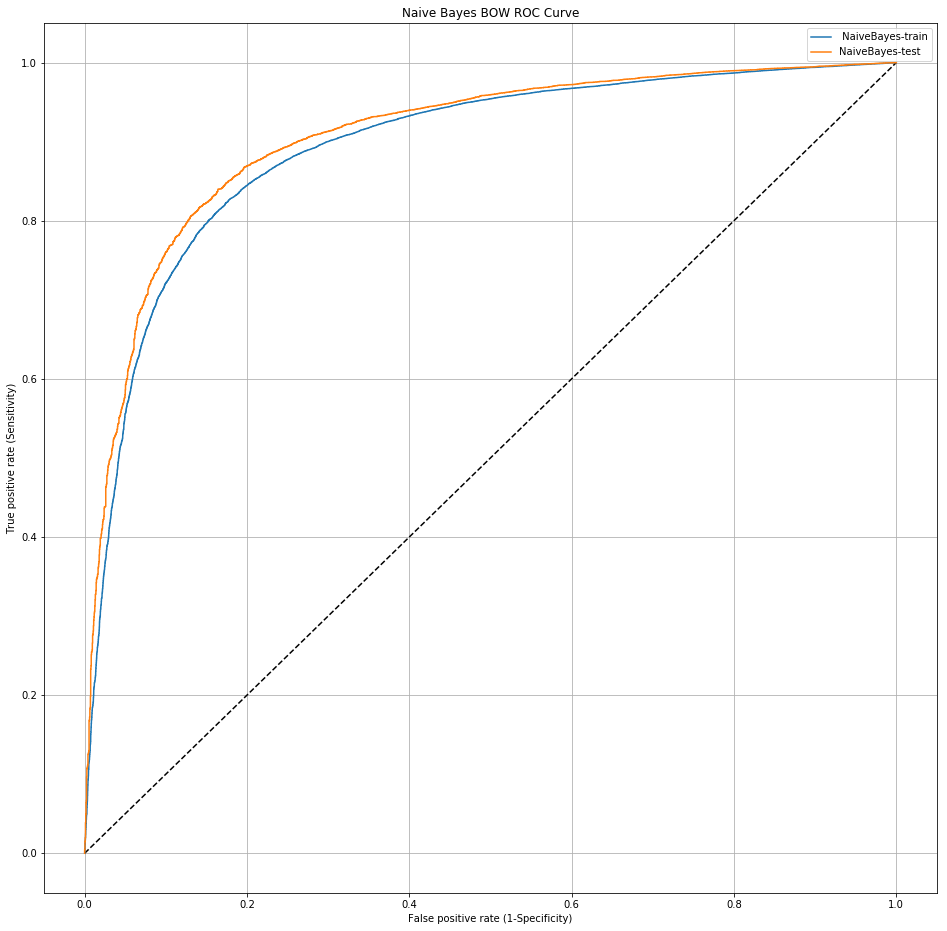

In [22]:
# display the roc auc cure
displaygraph = drawgraphs()
displaygraph.setdefaultparm()
displaygraph.graph_title='Naive Bayes BOW ROC Curve'
displaygraph.legnd_1 = ' NaiveBayes-train'
displaygraph.legnd_2 = 'NaiveBayes-test'
displaygraph.graph_parameters['show_legnd']= True
displaygraph.label_x='False positive rate (1-Specificity)'
displaygraph.label_y='True positive rate (Sensitivity)'
displaygraph.constructgraph(mnbayes.roc_curve_test['fpr_trn'],mnbayes.roc_curve_test['tpr_trn'],\
                            mnbayes.roc_curve_test['fpr'],mnbayes.roc_curve_test['tpr'])


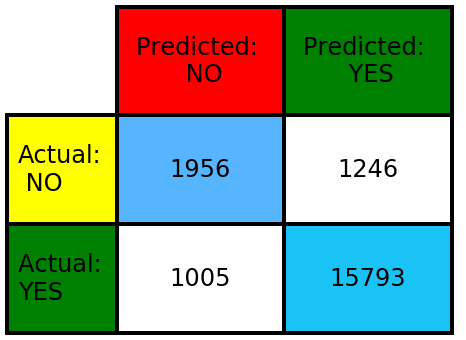

In [23]:
#display the confusion matrix for test data
data = [[mnbayes.confsnmtxytstpred['tn'] ,mnbayes.confsnmtxytstpred['fn']],[mnbayes.confsnmtxytstpred['fp'],mnbayes.confsnmtxytstpred['tp']]]
displaygraph.draw_table(data)

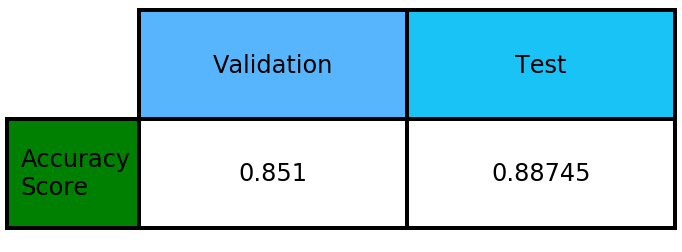

In [24]:
#displaying the accuracy score for validation and test data
data1= [[mnbayes.accuracy_score_val,mnbayes.accuracy_score_test]]
displaygraph.draw_accscore(data1)

In [63]:
mnbayes.outputdir = 'E:/appliedaiacourse/assignments/assign4-MultinomialNBayes'
mnbayes.exportopdatatocsv('NBayes_alpha',mnbayes.NBayes_alpha)
mnbayes.exportopdatatocsv('yprdprobatrn',mnbayes.yprdprobatrn)
mnbayes.exportopdatatocsv('yprdprobaval',mnbayes.yprdprobaval)
mnbayes.exportopdatatocsv('ytrn_predprob_actclf',mnbayes.ytrn_predprob_actclf)
mnbayes.exportopdatatocsv('ytst_predprob_actclf',mnbayes.ytst_predprob_actclf)
mnbayes.exportopdatatocsv('rocaucscoretrn',mnbayes.rocaucscoretrn)
mnbayes.exportopdatatocsv('rocaucscoreval',mnbayes.rocaucscoreval)
mnbayes.exportopdatatocsv('predicted',mnbayes.predicted)
mnbayes.exportopdatatocsv('test_predict',mnbayes.test_predict)


### [5.1.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

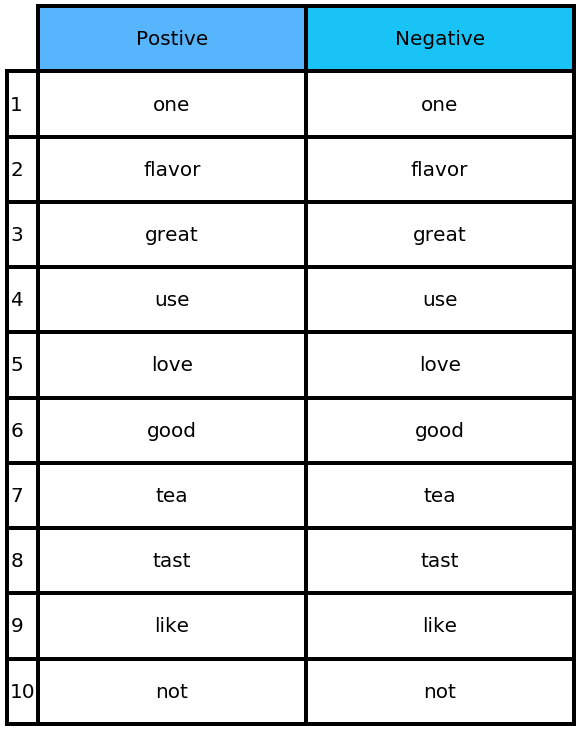

In [25]:
class_labels = mnbayes_clf.classes_
feature_names = mnbayes.count_vect.get_feature_names()
top10_negve = sorted(zip(mnbayes_clf.coef_[0], feature_names))[-10:]
top10_posve = sorted(zip(mnbayes_clf.coef_[0], feature_names))[-10:]
feat_pos=[]
feat_neg=[]
features=[]
for coef,feat in (top10_negve):    
    feat_pos.append(feat)
    
for cef,feat in (top10_posve):   
    feat_neg.append(feat)
    
i=0
while i< int(len(feat_pos)):
    feat_item=[]
    feat_item.append(feat_pos[i])
    feat_item.append(feat_neg[i])
    features.append(feat_item)
    i +=1
    
displaygraph = drawgraphs()
displaygraph.setdefaultparm()
displaygraph.draw_posnegwords(features)


### [5.1.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [0]:
# Please write all the code with proper documentation

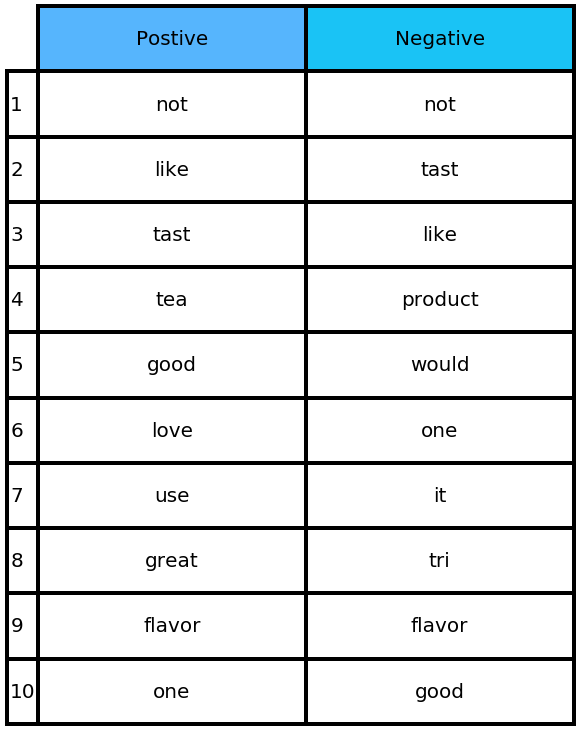

In [27]:
feat1_pos=[]
feat0_neg=[]
features1=[]

class_labels = mnbayes_clf.classes_
feature_names = mnbayes.count_vect.get_feature_names()
top10n_neg = sorted(zip(mnbayes_clf.feature_count_[0], feature_names),reverse=True)[:10]
top10n_pos = sorted(zip(mnbayes_clf.feature_count_[1], feature_names),reverse=True)[:10]

for coef, feat in top10n_neg:
    feat0_neg.append(feat)


for coef, feat in top10n_pos:
    feat1_pos.append(feat)
    
i=0
while i< int(len(feat1_pos)):
    feat_item=[]
    feat_item.append(feat1_pos[i])
    feat_item.append(feat0_neg[i])
    features1.append(feat_item)
    i +=1
    
displaygraph = drawgraphs()
displaygraph.setdefaultparm()
displaygraph.draw_posnegwords(features1)

### [5.1.3] Feature Engineering<font color='red'> SET 1</font>

VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool. If doesn’t require any training data but is constructed from a generalizable, valence-based, human-curated gold standard sentiment lexicon.The Compound score is a metric that calculates the sum of all the positive/negative/neutral ratings which have been normalized between -1(most extreme negative) and +1 (most extreme positive).I have used the compund score on the Summary text as a new feature .
I have also added the len of summary text as the second new feature.

In [33]:
import re

score_summ=[]
len_summ=[]
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()
for count,summ in final['Summary'].iteritems():
    #print(len(final['Summary'][count]),final['Summary'][count])
    #len_summ = len(re.findall(r'\w+', final['Summary'][count])),final['Summary'][count]
    len_summ.append(len(re.findall(r'\w+', final['Summary'][count])))
    if (analyser.polarity_scores(final['Summary'][count]))['compound'] < 0:
        score_summ.append(0.0)
    else:
        score_summ.append((analyser.polarity_scores(final['Summary'][count]))['compound'])


In [34]:
print(final.shape)
print(len(score_summ))
print(len(len_summ))

(364171, 10)
364171
364171


#### Adding two new featues ####

In [35]:
new_scoresumm = pd.DataFrame((np.asarray(score_summ)).reshape(-1,1))
new_lensumm = pd.DataFrame((np.asarray(len_summ)).reshape(-1,1))
final_fteng = final.append({'score_summ':new_scoresumm}, ignore_index=True)
final_fteng= final_fteng.append({'len_summ':new_lensumm}, ignore_index=True)

In [38]:
# cross checking the final dimensions
print(final_fteng.columns)
print(final_fteng.shape)

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text',
       'score_summ', 'len_summ'],
      dtype='object')
(364173, 12)


In [39]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [40]:
# get 100k rows for processig
data_set = final_fteng[:100000]
f10Xdata=data_set['Text']
f10ydata=data_set['Score']


In [41]:
print(type(data_set))
print(data_set.shape)
print(type(f10Xdata))
print(len(f10ydata))

<class 'pandas.core.frame.DataFrame'>
(100000, 12)
<class 'pandas.core.series.Series'>
100000


In [42]:
#function to split the data into train/test/cross validate
def splitdatasets(xdata,ydata):
    #split into train and test sets (80/20)
    X_data = xdata
    y_data = ydata

    X_train8, X_test8, y_train8, y_test8 = train_test_split(X_data, y_data, stratify=y_data,test_size=0.2, random_state=42) 
    X_trn8, X_val8, y_trn8, y_val8   = train_test_split(X_train8, y_train8, test_size=0.2, random_state=42)     

    
    return [X_trn8,X_test8,X_val8,y_trn8, y_test8,y_val8]

In [43]:
# calling functon to split data into train , test and validation
return_list14 = splitdatasets(f10Xdata,f10ydata)
xtrain = return_list14[0]
xtest  = return_list14[1]
xval  = return_list14[2]
y_trn = return_list14[3]
y_test = return_list14[4]
y_val = return_list14[5]

In [44]:
"""
    Set of functions to pre-proces text
"""
dictexpand = {row[0] : row[1] for _, row in pd.read_csv("E:/appliedaiacourse/assignments/dblite/expansions2.txt").iterrows()}
contractions_re = re.compile('(%s)' % '|'.join(dictexpand.keys()))


# remove html
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

# remove any text between square brackers
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)    
    return text

 # this expands contractions eg y'a'' to you all
def expand_contractions(s, contractions_dict=dictexpand):
    #print(s)
    def replace(match):
        #print(match)
        return contractions_dict[match.group(0)]
    #print(contractions_re.sub(replace, s)+ "|\t" + s)
    return contractions_re.sub(replace, s)

# remove common words
def remove_cmn_words(sumtext) :
    text = ' '.join(e.lower() for e in sumtext.split() if e.lower() not in stopwords)
    return text

def remove_num_spechar(text):
    #remove words with numbers
    text = re.sub('[^A-Za-z0-9]+', ' ', text)
    #remove spacial character:
    text = re.sub("\S*\d\S*", "", text).strip()
    return text

# tokenizing and porter stemming 
def stem_word(sumtext):
    # this instantiates the Porter stemmer
    #porter=PorterStemmer()
    stemer= SnowballStemmer("english")
    
    sumtxt_token = word_tokenize(sumtext)    
    smtxt_stemed =[]
    for token in sumtxt_token:        
        #smtxt_stemed.append(porter.stem(token))
        smtxt_stemed.append(stemer.stem(token))
        smtxt_stemed.append(" ")
    return "".join(smtxt_stemed)

#print(contractions_re)


"""
main loop that processes text in summary and stores in sumpreproc
at the end we print for a simple check

Expansions2.txt is the file that contains a dictionary of contractions and
expansions. This  approach allows us to add another items later on.
"""

def preproces_txt(textcorpus):   
    
    sumwordcnt = []
    sumscore = []
    sumpreproc = []
    sumpreproc2 = []
    unstemmed_summ = []    
    i=0

    all_positive_words=[] # store words from +ve reviews
    all_negative_words=[] # store words from -ve reviews

    for sumstr in textcorpus:  #final['Text'].values :
        prcdtxt1 = denoise_text(sumstr)    
        prcdtxt2 = remove_cmn_words(prcdtxt1)    
        prcdtxt3 = expand_contractions(prcdtxt2)   
        prcdtxt4 = remove_num_spechar(prcdtxt3)
        # unstemmed_stem will contain the summary text before stemming
        # used for bi-grams and n-grams
        unstemmed_summ.append(prcdtxt4)

        prcdtxt4 = stem_word(prcdtxt4)        

        sumpreproc.append(prcdtxt4)

        sumwordcnt.append(len(sumstr.split(" ")))
        if (final['Score'].values)[i] == 1: 
            all_positive_words.append(prcdtxt4) #list of all words used to describe positive reviews
        if(final['Score'].values)[i] == 0:
            all_negative_words.append(prcdtxt4) #list of all words used to describe negative reviews reviews
        i = i + 1
        print("Processed {0} word\n".format(i))
    print(len(sumpreproc))
    print("Process Complete...")
    return sumpreproc


In [70]:
print(xtrain[:10])

516646    I have ordered the liquid coffee creamers in t...
295864    I made this spaghetti for my family when my ki...
372255    So happy to have found these low carb snack pa...
197368    Out of all their different kinds of cookies, t...
371961    These are a great quick meal, buying in bulk i...
476358    It taste a little less like sugar and more lik...
438301    This tea is just so so so so so so so gooodddd...
131253    This is a lovely pasta made with a different w...
195814    I ordered this to use in my popcorn machine.  ...
189039    Premium chocolates (such as Black Panther) hav...
Name: Text, dtype: object


#preprocess the data corpus stored in train/test/cross-validate
X_train = preproces_txt(xtrain)
X_test  = preproces_txt(xtest)
X_val   = preproces_txt(xval)

In [46]:
# function to write data to external storage for easier retrieval in subsequent runs
def write_data(fnme,opdata):    
    fname = 'E:/appliedaiacourse/assignments/dblite/' + fnme
    with open(fname, 'wb') as fp:
        pickle.dump(opdata, fp)

In [47]:
# actual writing to eternal storage
write_data('pproc_fteng_xtrain',X_train)
write_data('pproc_fteng_xtest',X_test)
write_data('pproc_fteng_xval',X_val)
write_data('fteng_ytrain',y_trn)
write_data('fteng_ytest',y_test)
write_data('fteng_yval',y_val)

In [48]:
#create the Mutlinomial NaiveBayes object
mnbayes_feateng = multiNaiveBayes()

#create the actual Multinomial NaiveBayes lassifier
mnbayes_feateng_clf = mnbayes_feateng.multNBClasify()

In [49]:
#set the train/test/validate of the feature engineered data corpus 
mnbayes_feateng.xtrain = X_train
mnbayes_feateng.xtest = X_test
mnbayes_feateng.xval = X_val
mnbayes_feateng.ytrain = y_trn
mnbayes_feateng.ytest = y_test
mnbayes_feateng.yval = y_val

In [50]:
#using the Bag of word vectorizer on the data
mnbayes_feateng.BOWVectorizer()

some feature names  ['abl', 'absolut', 'acid', 'across', 'actual', 'ad', 'add', 'addict', 'addit', 'advertis']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (64000, 1000)
the number of unique words  1000


In [51]:
# print shapes of input datasets for confirmation
print((mnbayes_feateng.xtrain).shape)
print((mnbayes_feateng.xtest).shape)
print((mnbayes_feateng.xval).shape)
print((mnbayes_feateng.ytrain).shape)
print((mnbayes_feateng.ytest).shape)
print((mnbayes_feateng.yval).shape)

(64000, 1000)
(20000, 1000)
(16000, 1000)
(64000,)
(20000,)
(16000,)


In [52]:
# calculate ROCAUCSCORE
mnbayes_feateng.calcrocaucscore_naivebayes(100000000)

Fitting probability generation and roc auc score generation for training data complete...
Fitting probability generation and roc auc score generation for validation data complete...
Predicting labels for training data complete...
Fitting probability generation and roc auc score generation for training data complete...
Fitting probability generation and roc auc score generation for validation data complete...
Predicting labels for training data complete...
Fitting probability generation and roc auc score generation for training data complete...
Fitting probability generation and roc auc score generation for validation data complete...
Predicting labels for training data complete...
Fitting probability generation and roc auc score generation for training data complete...
Fitting probability generation and roc auc score generation for validation data complete...
Predicting labels for training data complete...
Fitting probability generation and roc auc score generation for training data co

In [53]:
#print rocaucscore resulst
print(mnbayes_feateng.rocaucscoretrn)
print(mnbayes_feateng.rocaucscoreval)
print( mnbayes_feateng.NBayes_alpha)

[0.9053365680876713, 0.9053365680876713, 0.9053365680876713, 0.9053365680876713, 0.9053365680876713, 0.9053365700261883, 0.9053365758417397, 0.9053365797187738, 0.90533656227212, 0.9053368045867547, 0.9053378688326301, 0.9053488893022151, 0.9051831557846834, 0.8919818447950495, 0.693085396430503, 0.5464037119686502, 0.514971675280183, 0.5096905828988257, 0.5091040108934115, 0.5090437501515437]
[0.9163071019388954, 0.9163071019388954, 0.9163071019388954, 0.9163071019388954, 0.9163071019388954, 0.9163071327455263, 0.9163071327455263, 0.9163071943587884, 0.9163067014526929, 0.916305715640502, 0.9163012948889582, 0.9161995867968202, 0.9123514072961931, 0.8161240150503948, 0.5781911418366863, 0.5203568985165499, 0.5087069705301304, 0.5072543146535068, 0.5071018218302195, 0.5070857407688547]
[1e-11, 9.999999999999999e-11, 9.999999999999999e-10, 9.999999999999999e-09, 9.999999999999998e-08, 9.999999999999997e-07, 9.999999999999997e-06, 9.999999999999998e-05, 0.0009999999999999998, 0.009999999

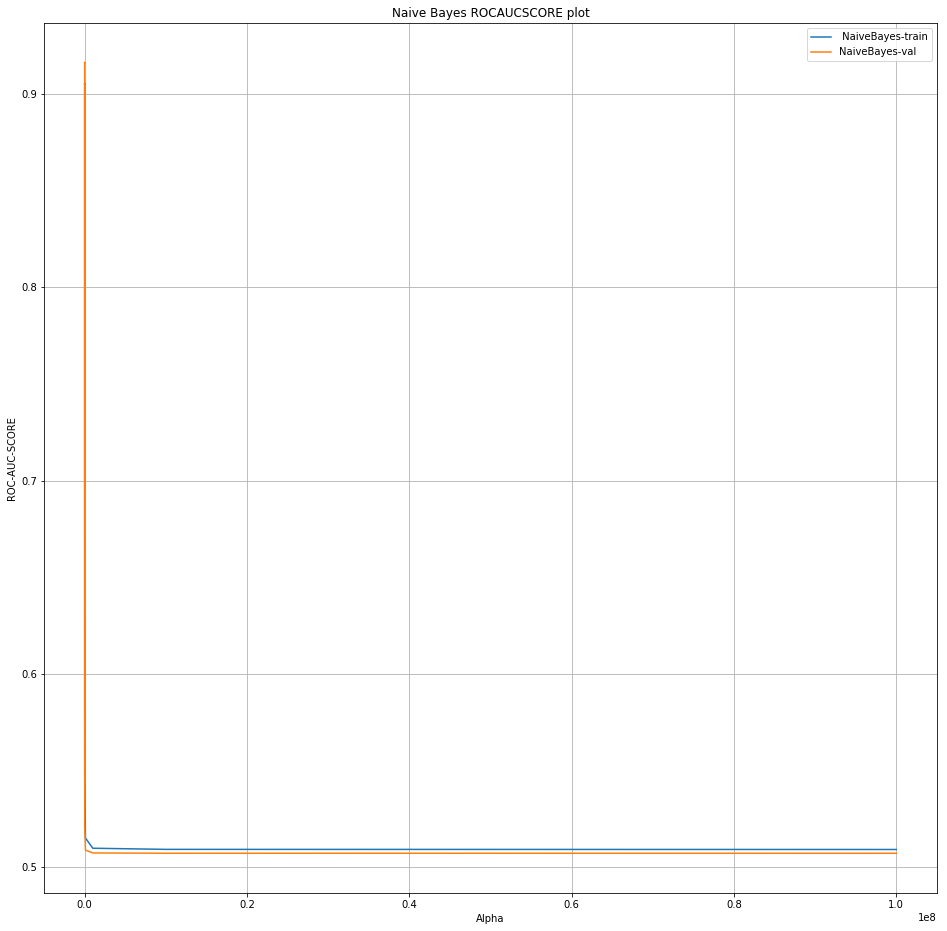

In [54]:
#display roc auc graph
displaygraph = drawgraphs()
displaygraph.setdefaultparm()
displaygraph.graph_title='Naive Bayes ROCAUCSCORE plot'
displaygraph.legnd_1 = ' NaiveBayes-train'
displaygraph.legnd_2 = 'NaiveBayes-val'
displaygraph.graph_parameters['show_legnd']= True
displaygraph.label_x='Alpha'
displaygraph.label_y='ROC-AUC-SCORE'
displaygraph.Xdata = mnbayes_feateng.NBayes_alpha
displaygraph.ydatatrn = mnbayes_feateng.rocaucscoretrn
displaygraph.ydataval = mnbayes_feateng.rocaucscoreval
displaygraph.rocacuscoregraph()

In [55]:
#clssify test data with actualClasifier_naivebayes function and hyper parameter 10
mnbayes_feateng.actualClasifier_naivebayes(10)

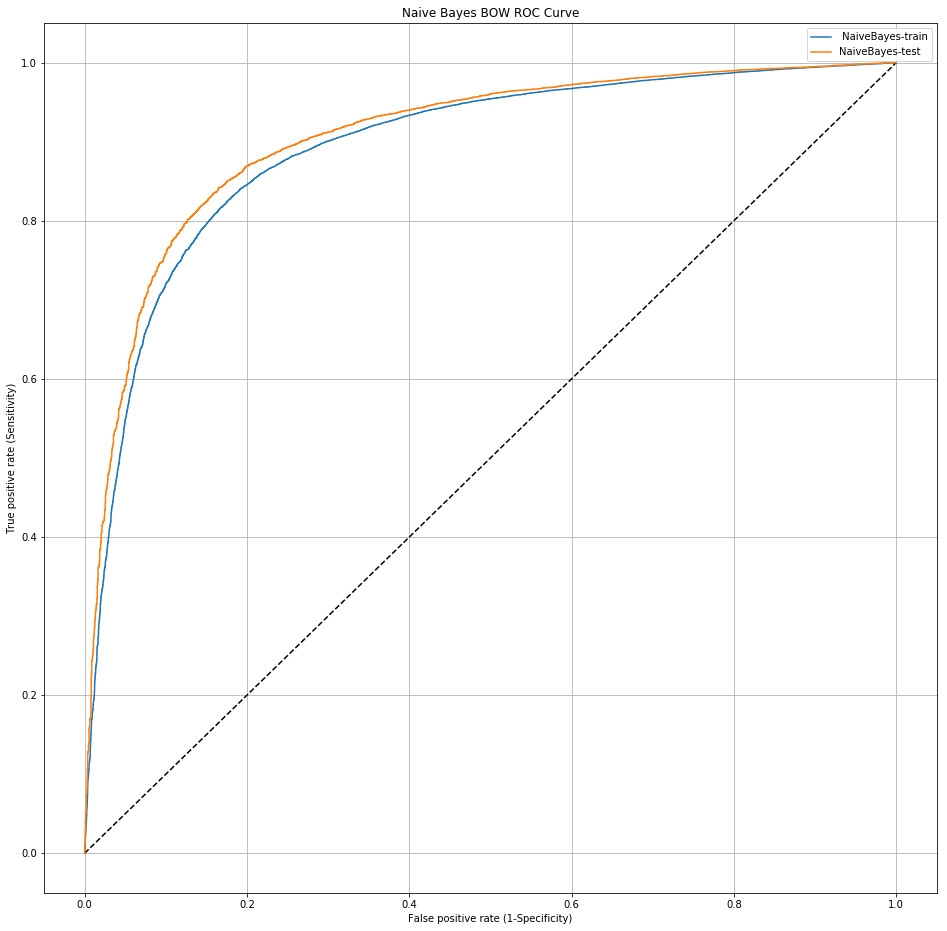

In [56]:
# displayig ROCAUC graphs for test data
displaygraph = drawgraphs()
displaygraph.setdefaultparm()
displaygraph.graph_title='Naive Bayes BOW ROC Curve'
displaygraph.legnd_1 = ' NaiveBayes-train'
displaygraph.legnd_2 = 'NaiveBayes-test'
displaygraph.graph_parameters['show_legnd']= True
displaygraph.label_x='False positive rate (1-Specificity)'
displaygraph.label_y='True positive rate (Sensitivity)'
displaygraph.constructgraph(mnbayes_feateng.roc_curve_test['fpr_trn'],mnbayes_feateng.roc_curve_test['tpr_trn'],\
                            mnbayes_feateng.roc_curve_test['fpr'],mnbayes_feateng.roc_curve_test['tpr'])

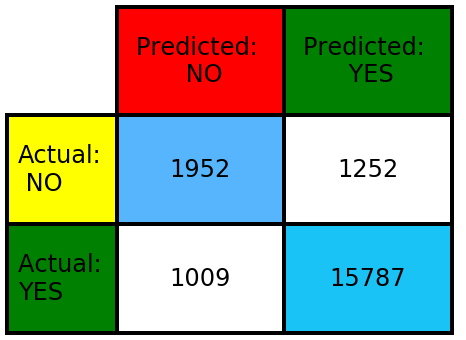

In [57]:
data = [[mnbayes_feateng.confsnmtxytstpred['tn'] ,mnbayes_feateng.confsnmtxytstpred['fn']],[mnbayes_feateng.confsnmtxytstpred['fp'],mnbayes_feateng.confsnmtxytstpred['tp']]]
							
# display confusion matrix for test data
displaygraph.draw_table(data)

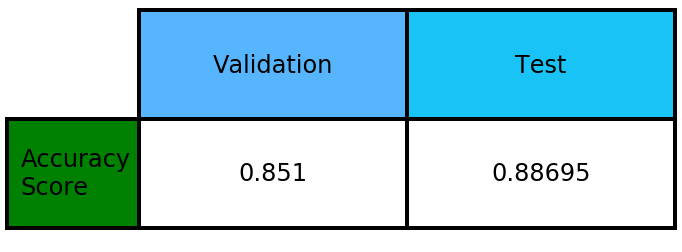

In [58]:
#display the accuracy score for validation and test data
data1= [[mnbayes_feateng.accuracy_score_val,mnbayes_feateng.accuracy_score_test]]

displaygraph.draw_accscore(data1)

## [5.2] Applying Naive Bayes on TFIDF,<font color='red'> SET 2</font>

In [0]:
# Please write all the code with proper documentation

some sample features(unique words in the corpus) ['ab', 'abandon', 'abc', 'abdomin', 'abil', 'abl', 'abl buy', 'abl chew', 'abl drink', 'abl eat']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (64000, 40440)
the number of unique words including both unigrams and bigrams  40440
(64000, 40440)
(20000, 40440)
(16000, 40440)
(64000,)
(20000,)
(16000,)
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
Fitting 5 folds for each of 22 candidates, totalling 110 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] alpha=1e-11 .....................................................
[CV] ............ alpha=1e-11, score=0.8341024208147471, total=   0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[CV] alpha=1e-11 .....................................................
[CV] ............ alpha=1e-11, score=0.8523605187019969, total=   0.0s
[Parallel(n_jobs=1)]: 

[CV] alpha=1e-06 .....................................................
[CV] ............ alpha=1e-06, score=0.8736130091063046, total=   0.0s
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    4.8s remaining:    0.0s
[CV] alpha=1e-05 .....................................................
[CV] ............ alpha=1e-05, score=0.8839441879069923, total=   0.0s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    5.0s remaining:    0.0s
[CV] alpha=1e-05 .....................................................
[CV] ............. alpha=1e-05, score=0.898310392896685, total=   0.0s
[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed:    5.1s remaining:    0.0s
[CV] alpha=1e-05 .....................................................
[CV] ............ alpha=1e-05, score=0.8959378980533712, total=   0.0s
[Parallel(n_jobs=1)]: Done  38 out of  38 | elapsed:    5.3s remaining:    0.0s
[CV] alpha=1e-05 .....................................................
[CV] ............ alpha=1e-05, score=0.89

[CV] alpha=1000 ......................................................
[CV] ............. alpha=1000, score=0.6467784518359359, total=   0.0s
[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   10.1s remaining:    0.0s
[CV] alpha=1000 ......................................................
[CV] ............. alpha=1000, score=0.6481250353717543, total=   0.0s
[Parallel(n_jobs=1)]: Done  73 out of  73 | elapsed:   10.3s remaining:    0.0s
[CV] alpha=1000 ......................................................
[CV] ............. alpha=1000, score=0.6335037214280215, total=   0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:   10.4s remaining:    0.0s
[CV] alpha=1000 ......................................................
[CV] .............. alpha=1000, score=0.633677328600126, total=   0.0s
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:   10.5s remaining:    0.0s
[CV] alpha=10000 .....................................................
[CV] ............ alpha=10000, score=0.62

       scoring='roc_auc', verbose=100)
Fitting probability generation and roc auc score generation for training data complete...
Fitting probability generation and roc auc score generation for validation data complete...
Predicting labels for training data complete...
Fitting probability generation and roc auc score generation for training data complete...
Fitting probability generation and roc auc score generation for validation data complete...
Predicting labels for training data complete...
Fitting probability generation and roc auc score generation for training data complete...
Fitting probability generation and roc auc score generation for validation data complete...
Predicting labels for training data complete...
Fitting probability generation and roc auc score generation for training data complete...
Fitting probability generation and roc auc score generation for validation data complete...
Predicting labels for training data complete...
Fitting probability generation and roc au

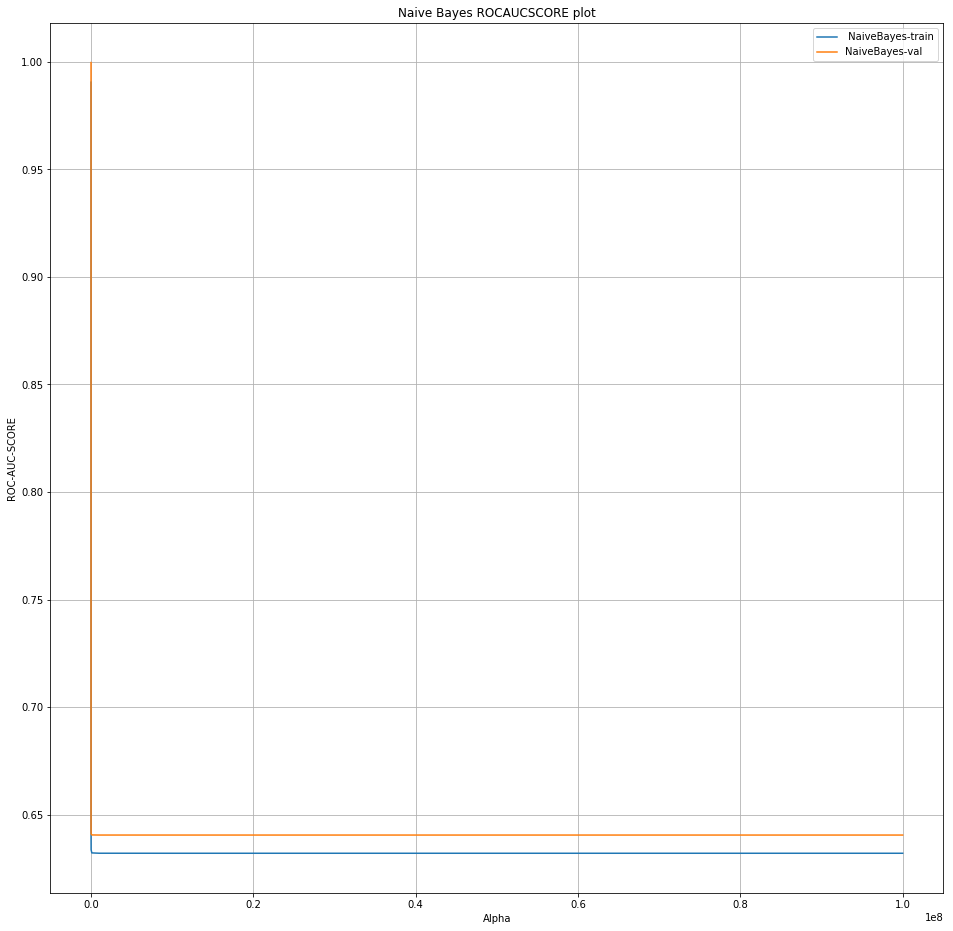

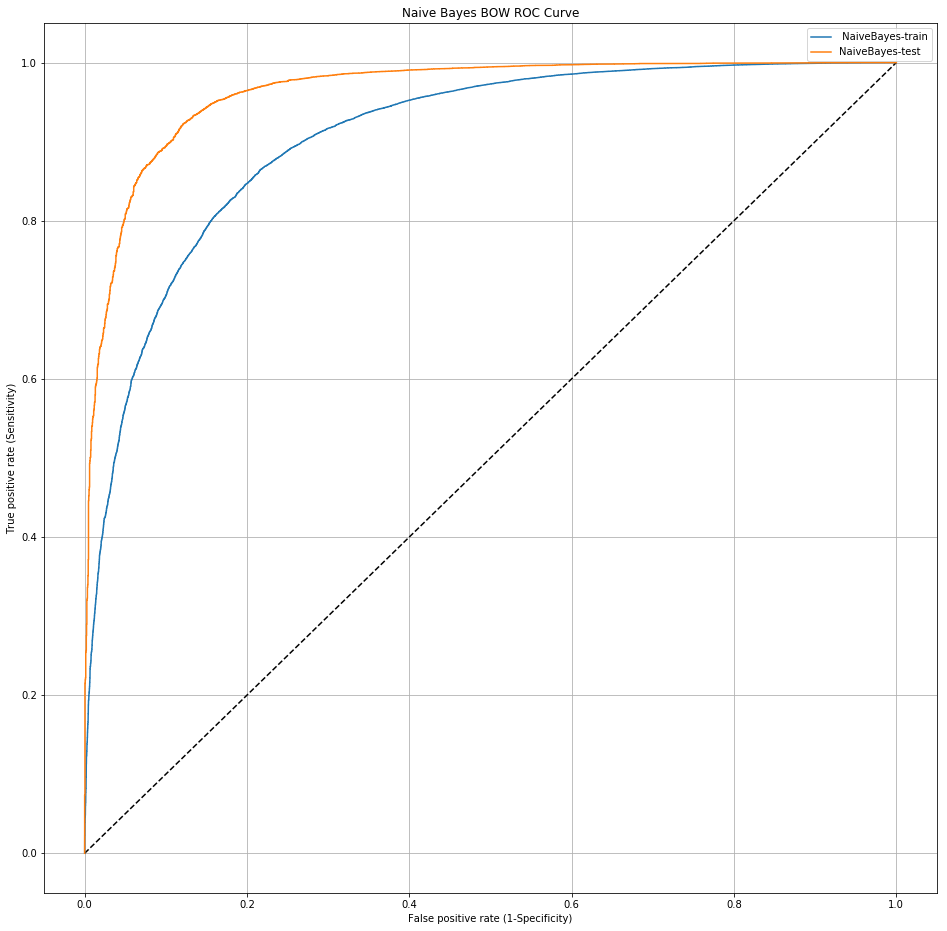

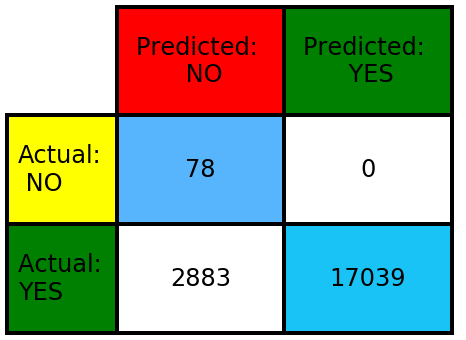

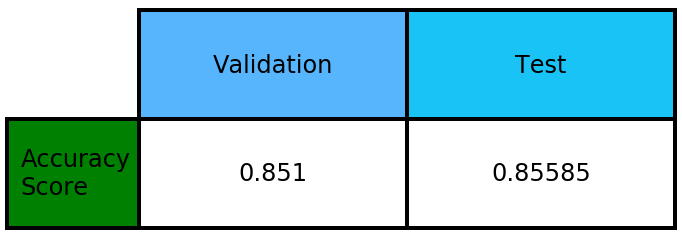

In [59]:
#"""
#crate python object for Multinomial Naive Bayes 
mnbayes_tfidf = multiNaiveBayes()

#clasifier for the actual classification
mnbayes_tfidf_clf = mnbayes_tfidf.multNBClasify()

#load data
mnbayes_tfidf.xtrain,mnbayes_tfidf.xtest,mnbayes_tfidf.xval, mnbayes_tfidf.ytrain,mnbayes_tfidf.ytest,mnbayes_tfidf.yval = load_data()

#tfidf vectorizer for the data corpus
mnbayes_tfidf.tfIdfVectorizer()

#print the shapes for confirmation
print((mnbayes_tfidf.xtrain).shape)
print((mnbayes_tfidf.xtest).shape)
print((mnbayes_tfidf.xval).shape)
print((mnbayes_tfidf.ytrain).shape)
print((mnbayes_tfidf.ytest).shape)
print((mnbayes_tfidf.yval).shape)
#print the classifier
print(mnbayes_tfidf.getNBClassifier())

#hyper parameter tune alpha for the tfidf vectorized corpus
return_63 = mnbayes_tfidf.hyperparamtuning([0.00000000001,0.0000000001,0.0000000001,0.000000001,0.00000001,0.0000001,0.000001,0.00001,0.0001,0.001,0.01,1,10,100,1000,10000,100000,1000000,10000000,100000000,1000000000,10000000000],'roc_auc')

#print the results of the hyper parameter tuning corpus
print(return_63[0])
print(return_63[1])
print(return_63[2])

#calculate roc auc score varying alpha
mnbayes_tfidf.calcrocaucscore_naivebayes(100000000)

#print output data for confirmation
print(mnbayes_tfidf.rocaucscoretrn)
print(mnbayes_tfidf.rocaucscoreval)
print( mnbayes_tfidf.NBayes_alpha)
#"""

# display the rocauc score
displaygraph = drawgraphs()
displaygraph.setdefaultparm()
displaygraph.graph_title='Naive Bayes ROCAUCSCORE plot'
displaygraph.legnd_1 = ' NaiveBayes-train'
displaygraph.legnd_2 = 'NaiveBayes-val'
displaygraph.graph_parameters['show_legnd']= True
displaygraph.label_x='Alpha'
displaygraph.label_y='ROC-AUC-SCORE'
displaygraph.Xdata = mnbayes_tfidf.NBayes_alpha
displaygraph.ydatatrn = mnbayes_tfidf.rocaucscoretrn
displaygraph.ydataval = mnbayes_tfidf.rocaucscoreval
displaygraph.rocacuscoregraph()

#process the unseen or test data with the hyper parameter tuned value for alpha
mnbayes_tfidf.actualClasifier_naivebayes(1)


# testing code for displayig graphs
displaygraph = drawgraphs()
displaygraph.setdefaultparm()
displaygraph.graph_title='Naive Bayes BOW ROC Curve'
displaygraph.legnd_1 = ' NaiveBayes-train'
displaygraph.legnd_2 = 'NaiveBayes-test'
displaygraph.graph_parameters['show_legnd']= True
displaygraph.label_x='False positive rate (1-Specificity)'
displaygraph.label_y='True positive rate (Sensitivity)'
displaygraph.constructgraph(mnbayes_tfidf.roc_curve_test['fpr_trn'],mnbayes_tfidf.roc_curve_test['tpr_trn'],\
                            mnbayes_tfidf.roc_curve_test['fpr'],mnbayes_tfidf.roc_curve_test['tpr'])

#display conusion matrix
data = [[mnbayes_tfidf.confsnmtxytstpred['tn'] ,mnbayes_tfidf.confsnmtxytstpred['fn']],[mnbayes_tfidf.confsnmtxytstpred['fp'],mnbayes_tfidf.confsnmtxytstpred['tp']]]
displaygraph.draw_table(data)

#display accuracy score
data1= [[mnbayes_tfidf.accuracy_score_val,mnbayes_tfidf.accuracy_score_test]]

displaygraph.draw_accscore(data1)

### [5.2.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [0]:
# Please write all the code with proper documentation

In [60]:
feature_names = mnbayes_tfidf.tf_idf_vect.get_feature_names()

In [61]:
top10_posve = np.argsort(mnbayes_tfidf_clf.feature_log_prob_[1])[-10:]

print("%s: %s" % (1,
    " ".join(feature_names[j] for j in top10_posve)))
for k in top10_posve:
    print(" {0} ".format(mnbayes_tfidf_clf.feature_log_prob_[1][k]))

1: product flavor use like tast good not love great tea
 -6.240321352140638 
 -6.217273141048056 
 -6.215149461835411 
 -6.14808490415411 
 -6.1233938511973225 
 -6.097917976278151 
 -6.043091648591179 
 -6.0426606142292085 
 -6.026088459211894 
 -5.930454976358275 


### [5.2.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [114]:
# Please write all the code with proper documentation

In [62]:

top10_negve = np.argsort(mnbayes_tfidf_clf.feature_log_prob_[0])[-10:]

print("%s: %s " % (0,
    " ".join(feature_names[j] for j in top10_negve)))
for k in top10_negve:
    print(" {0} ".format(mnbayes_tfidf_clf.feature_log_prob_[0][k]))

0: tri tea it order one would like product tast not 
 -7.188426950174545 
 -7.177554369700099 
 -7.147491643515288 
 -7.131539094498196 
 -7.107405544073313 
 -6.929602083577947 
 -6.751295136319813 
 -6.698598341648012 
 -6.61501140587509 
 -6.201522592294338 


# [6] Conclusions

In [0]:
# Please compare all your models using Prettytable library

In [63]:
from prettytable import from_html_one
L1  =  '<html>'
L2  =  '<head>'

L3  =  '<STYLE TYPE="text/css">'
L4  =  '<!--'
L5  =  'td {font-family: Arial; font-size: 10pt; background-color: #000000; color: white;}'
L6  =  'THEAD {font-family: Arial; font-size: 14pt; background-color: #000000; color: white;}'
L7  =  '--->'
L8  =  '</STYLE>'

L9  =  '</head>'
L10  =  '<body>'

L11  =  '<table border=1 solid> '
L12  =  '<tr>'
L13  =  '<th>Vectorizer </th>'
L15  =  '<th>Hyper Parameter</th>'
L16  =  '<th>AUC</th>'
L17  =  '</tr>'
L18  =  '<tr><td> BOW </td><td> 1 </td><td> 0.88745</td></tr>'
L19  =  '<tr><td> BOW Feat Engg. </td><td> 1 </td><td> 0.88695</td></tr>'
L20  =  '<tr><td> TFIDF </td><td> 1 </td><td> 0.8558</td></tr>'

L22  =  '</table>'

L23  =  '</body>'
L24  =  '</html>'

html_string = L1+L2+L3+L4+L5+L6+L7+L8+L9+L10+L11+L12+L13+L15+L16+L17+L18+L19+L20+L22+L23+L24
#html_string = L1+L2+L3+L4+L5+L6+L7+L8+L9+L10+L11+L12+L13+L14+L15+L16+L17+L18+L22+L23+L24
tbl = from_html_one(html_string)

print(tbl)

+----------------+-----------------+---------+
|   Vectorizer   | Hyper Parameter |   AUC   |
+----------------+-----------------+---------+
|      BOW       |        1        | 0.88745 |
| BOW Feat Engg. |        1        | 0.88695 |
|     TFIDF      |        1        |  0.8558 |
+----------------+-----------------+---------+
